In [1]:
# Essentials
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Tools
from IPython.display import clear_output
import copy
import sys
import importlib
import pandas as pd
import time as time

# Specialized packages
from casadi import *
from casadi.tools import *

# Plotting
from matplotlib.animation import FuncAnimation, ImageMagickFileWriter
from cycler import cycler
import time as time
# Visualization
from mpl_toolkits.mplot3d import Axes3D

# Control packages
import do_mpc
import control



In [2]:
import importlib

import CSTRmodel
importlib.reload(CSTRmodel)

cstr = CSTRmodel.CSTR_Cascade(n_reac=4)
#qc = qcmodel.BiasedQuadcopter()
#qc = qcmodel.MeasuredBiasedQuadcopter()
# qc = qcmodel.WeightUncertainQuadcopter()

cstr.get_model()

# Simulator

In [3]:
import CSTRcontrol
importlib.reload(CSTRcontrol)
simulator=CSTRcontrol.get_simulator(t_step=1,CSTR=cstr)

# Controller

Just some basic MPC

In [4]:
import CSTRcontrol
importlib.reload(CSTRcontrol)
mpc, mpc_tvp_template,mpc_p_template=CSTRcontrol.get_MPC(t_step=1,CSTR=cstr,n_robust=0,n_scenarios=1)

# Run Closed Loop

In [5]:
sim_tvp_template=simulator.get_tvp_template()
sim_tvp_template['k1_mean']=cstr.k1_0
sim_tvp_template['k2_mean']=cstr.k2_0
sim_p_template=simulator.get_p_template()
sim_p_template['k1_var']=1.3
sim_p_template['k2_var']=1.3
sim_tvp_template['delH1_mean']=cstr.delH1_0
sim_tvp_template['delH2_mean']=cstr.delH2_0
sim_p_template['delH1_var']=1.3
sim_p_template['delH2_var']=1.3
simulator.set_tvp_fun(lambda t: sim_tvp_template)
simulator.set_p_fun(lambda t: sim_p_template)
simulator.setup()

In [6]:
tvp=np.zeros((cstr.np,1))
tvp[0:cstr.n_reac]=cstr.k1_0
tvp[cstr.n_reac:2*cstr.n_reac]=cstr.k2_0
tvp[2*cstr.n_reac:3*cstr.n_reac]=cstr.delH1_0
tvp[3*cstr.n_reac:4*cstr.n_reac]=cstr.delH2_0

for i in range(len(mpc_tvp_template['_tvp'])):
    mpc_tvp_template['_tvp',]=tvp

def mpc_tvp_fun(t_now):
    return mpc_tvp_template

mpc.set_tvp_fun(mpc_tvp_fun)


In [7]:
p_num=np.zeros((cstr.np,1))
p_num[0:cstr.n_reac]=1.0
p_num[cstr.n_reac:2*cstr.n_reac]=1.0
p_num[2*cstr.n_reac:3*cstr.n_reac]=1.0
p_num[3*cstr.n_reac:4*cstr.n_reac]=1.0

for i in range(len(mpc_p_template['_p'])):
    mpc_p_template['_p',]=p_num

def mpc_p_fun(t_now):
    return mpc_p_template

mpc.set_p_fun(mpc_p_fun)

In [8]:
mpc.setup()

In [9]:
mpc.reset_history()
simulator.reset_history()
x_0=0*np.ones((cstr.nx,1))
x_0[-cstr.n_reac:]=cstr.Tr_in
mpc.x0 = x_0



mpc.set_initial_guess()
mpc.opt_x_num['_u',:,:,'Tj']=cstr.Tr_in
mpc.opt_x_num['_u',:,:,'uB',0]=1.5
mpc.opt_x_num['_u',:,:,'uA',0]=1.5
simulator.x0 = x_0

x0 = simulator.x0

In [13]:
N_iter = 60
for k in range(N_iter):
    CSTRmodel.print_progress(k,N_iter)
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)
    
mpc_res = copy.copy(mpc.data)

Text(0.5, 0, 'time')

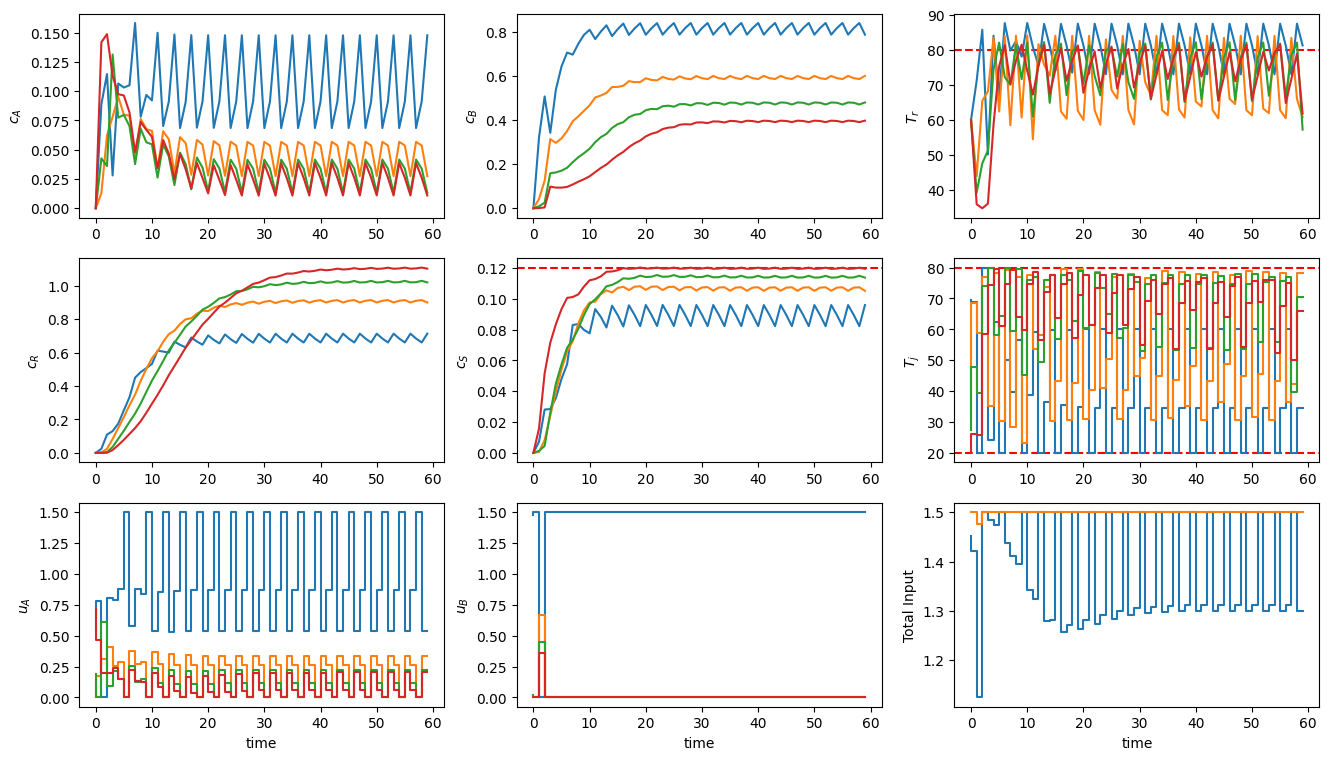

In [14]:
# plot the states
fig, ax = plt.subplots(3,3, sharex=False,sharey=False,figsize=(16,9))
ax[1,1].axhline(y=0.12,linestyle='--',color='red')
ax[0,2].axhline(y=80,linestyle='--',color='red')
ax[1,2].axhline(y=80,linestyle='--',color='red')
ax[1,2].axhline(y=20,linestyle='--',color='red')
ax[0,0].plot(mpc_res['_time'],mpc_res['_x','cA'])
ax[0,1].plot(mpc_res['_time'],mpc_res['_x','cB'])
ax[1,0].plot(mpc_res['_time'],mpc_res['_x','cR'])
ax[1,1].plot(mpc_res['_time'],mpc_res['_x','cS'])
ax[0,2].plot(mpc_res['_time'],mpc_res['_x','Tr'])
ax[1,2].step(mpc_res['_time'],mpc_res['_u','Tj'])
ax[2,0].step(mpc_res['_time'],mpc_res['_u','uA'])
ax[2,1].step(mpc_res['_time'],mpc_res['_u','uB'])
ax[2,2].step(mpc_res['_time'],np.sum(mpc_res['_u','uA'],axis=1))
ax[2,2].step(mpc_res['_time'],np.sum(mpc_res['_u','uB'],axis=1))


# Set labels
ax[0,0].set_ylabel('$c_A$')
ax[0,1].set_ylabel('$c_B$')
ax[1,0].set_ylabel('$c_R$')
ax[1,1].set_ylabel('$c_S$')
ax[2,0].set_ylabel('$u_A$')
ax[2,1].set_ylabel('$u_B$')
ax[0,2].set_ylabel('$T_r$')
ax[1,2].set_ylabel('$T_j$')
#ax[1,2].set_ylim([0,1])
ax[2,2].set_ylabel('Total Input')
ax[2,0].set_xlabel('time')
ax[2,1].set_xlabel('time')
ax[2,2].set_xlabel('time')

# Multi-Stage

In [10]:
import CSTRcontrol
importlib.reload(CSTRcontrol)
MSmpc, MSmpc_tvp_template,MSmpc_p_template=CSTRcontrol.get_MPC(t_step=1,CSTR=cstr,n_robust=1,n_scenarios=4)

# Run Closed Loop

In [11]:
sim_tvp_template=simulator.get_tvp_template()
sim_tvp_template['k1_mean']=cstr.k1_0
sim_tvp_template['k2_mean']=cstr.k2_0
sim_p_template=simulator.get_p_template()
sim_p_template['k1_var']=1.3
sim_p_template['k2_var']=1.3
sim_tvp_template['delH1_mean']=cstr.delH1_0
sim_tvp_template['delH2_mean']=cstr.delH2_0
sim_p_template['delH1_var']=1.3
sim_p_template['delH2_var']=1.3
simulator.set_tvp_fun(lambda t: sim_tvp_template)
simulator.set_p_fun(lambda t: sim_p_template)
simulator.setup()

In [12]:
tvp=np.zeros((cstr.np,1))
tvp[0:cstr.n_reac]=cstr.k1_0
tvp[cstr.n_reac:2*cstr.n_reac]=cstr.k2_0
tvp[2*cstr.n_reac:3*cstr.n_reac]=cstr.delH1_0
tvp[3*cstr.n_reac:4*cstr.n_reac]=cstr.delH2_0

for i in range(len(MSmpc_tvp_template['_tvp'])):
    MSmpc_tvp_template['_tvp',]=tvp

def MSmpc_tvp_fun(t_now):
    return MSmpc_tvp_template

MSmpc.set_tvp_fun(MSmpc_tvp_fun)


In [13]:
k1_scen=[1.3,1.3,0.7,0.7]
k2_scen=[1.3,0.7,1.3,0.7]
delH1_scen=[1.3,1.3,0.7,0.7]
delH2_scen=[1.3,0.7,1.3,0.7]

for i in range(len(MSmpc_p_template['_p'])):
    for k in range(cstr.n_reac):
        MSmpc_p_template['_p',i]=vertcat(k1_scen[i]*DM.ones(cstr.n_reac,1),k2_scen[i]*DM.ones(cstr.n_reac,1),delH1_scen[i]*DM.ones(cstr.n_reac,1),delH2_scen[i]*DM.ones(cstr.n_reac,1))

def MSmpc_p_fun(t_now):
    return MSmpc_p_template

MSmpc.set_p_fun(MSmpc_p_fun)

In [14]:
MSmpc_p_template['_p']

[DM([1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]),
 DM([1.3, 1.3, 1.3, 1.3, 0.7, 0.7, 0.7, 0.7, 1.3, 1.3, 1.3, 1.3, 0.7, 0.7, 0.7, 0.7]),
 DM([0.7, 0.7, 0.7, 0.7, 1.3, 1.3, 1.3, 1.3, 0.7, 0.7, 0.7, 0.7, 1.3, 1.3, 1.3, 1.3]),
 DM([0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7])]

In [15]:
MSmpc.setup()

In [16]:
MSmpc.reset_history()
simulator.reset_history()
x_0=0*np.ones((cstr.nx,1))
x_0[-cstr.n_reac:]=cstr.Tr_in
MSmpc.x0 = x_0



MSmpc.set_initial_guess()
MSmpc.opt_x_num['_u',:,:,'Tj']=cstr.Tr_in
MSmpc.opt_x_num['_u',:,:,'uB',0]=1.5
MSmpc.opt_x_num['_u',:,:,'uA',0]=1.5
simulator.x0 = x_0

x0 = simulator.x0

In [24]:
N_iter = 60
for k in range(N_iter):
    #CSTRmodel.print_progress(k,N_iter)
    u0 = MSmpc.make_step(x0)
    x0 = simulator.make_step(u0)
    
MSmpc_res = copy.copy(MSmpc.data)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   106980
Number of nonzeros in inequality constraint Jacobian.:     1120
Number of nonzeros in Lagrangian Hessian.............:    17216

Total number of variables............................:    18960
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    18080
                     variables with only upper bounds:        0
Total number of equality constraints.................:    16820
Total number of inequality constraints...............:      280
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      280

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

Text(0.5, 0, 'time')

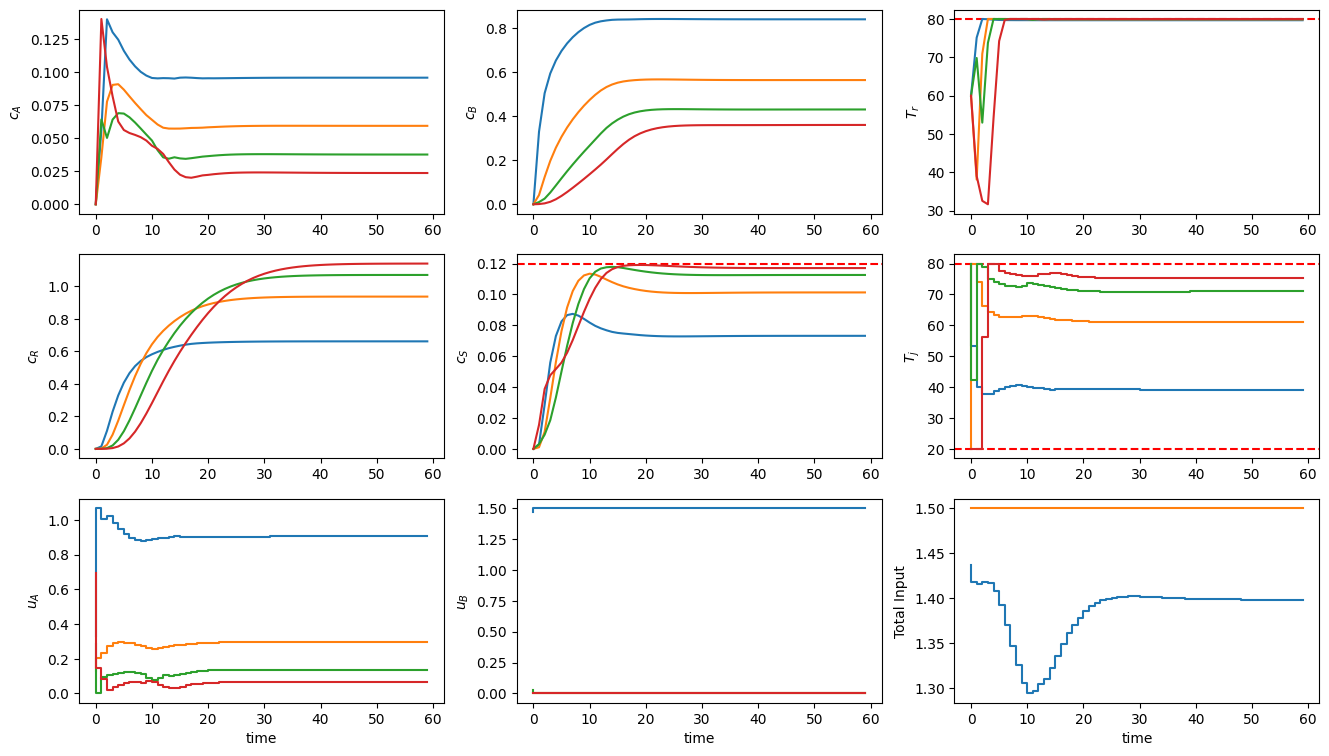

In [25]:
# plot the states
fig, ax = plt.subplots(3,3, sharex=False,sharey=False,figsize=(16,9))
ax[1,1].axhline(y=0.12,linestyle='--',color='red')
ax[0,2].axhline(y=80,linestyle='--',color='red')
ax[1,2].axhline(y=80,linestyle='--',color='red')
ax[1,2].axhline(y=20,linestyle='--',color='red')
ax[0,0].plot(MSmpc_res['_time'],MSmpc_res['_x','cA'])
ax[0,1].plot(MSmpc_res['_time'],MSmpc_res['_x','cB'])
ax[1,0].plot(MSmpc_res['_time'],MSmpc_res['_x','cR'])
ax[1,1].plot(MSmpc_res['_time'],MSmpc_res['_x','cS'])
ax[0,2].plot(MSmpc_res['_time'],MSmpc_res['_x','Tr'])
ax[1,2].step(MSmpc_res['_time'],MSmpc_res['_u','Tj'])
ax[2,0].step(MSmpc_res['_time'],MSmpc_res['_u','uA'])
ax[2,1].step(MSmpc_res['_time'],MSmpc_res['_u','uB'])
ax[2,2].step(MSmpc_res['_time'],np.sum(MSmpc_res['_u','uA'],axis=1))
ax[2,2].step(MSmpc_res['_time'],np.sum(MSmpc_res['_u','uB'],axis=1))


# Set labels
ax[0,0].set_ylabel('$c_A$')
ax[0,1].set_ylabel('$c_B$')
ax[1,0].set_ylabel('$c_R$')
ax[1,1].set_ylabel('$c_S$')
ax[2,0].set_ylabel('$u_A$')
ax[2,1].set_ylabel('$u_B$')
ax[0,2].set_ylabel('$T_r$')
ax[1,2].set_ylabel('$T_j$')
#ax[1,2].set_ylim([0,1])
ax[2,2].set_ylabel('Total Input')
ax[2,0].set_xlabel('time')
ax[2,1].set_xlabel('time')
ax[2,2].set_xlabel('time')

# LQR

Determine Steady State

In [17]:
print(cstr.model._rhs_fun)

rhs_fun:(_x[20],_u[12],_z[0],_tvp[16],_p[16],_w[0])->(_rhs[20]) SXFunction


In [17]:
J=mpc.lterm
g=[]
lb_g=[]
ub_g=[]

g.append(cstr.model._rhs_fun(cstr.model.x,cstr.model.u,[],tvp,np.ones((cstr.n_reac*4,1)),[]))
lb_g.append(np.zeros((cstr.nx,1)))
ub_g.append(np.zeros((cstr.nx,1)))
g.append(sum1(cstr.model.u['uA']))
g.append(sum1(cstr.model.u['uB']))
lb_g.append(np.zeros((2,1)))
ub_g.append(1.5*np.ones((2,1)))
g.append(cstr.model.x['cS'])
lb_g.append(np.zeros((cstr.n_reac,1)))
ub_g.append(0.12*np.ones((cstr.n_reac,1)))
g.append(cstr.model.x['Tr'])
lb_g.append(20*np.ones((cstr.n_reac,1)))
ub_g.append(80*np.ones((cstr.n_reac,1)))
g.append(cstr.model.u['Tj'])
lb_g.append(20*np.ones((cstr.n_reac,1)))
ub_g.append(80*np.ones((cstr.n_reac,1)))


g=vertcat(*g)
lb_g=vertcat(*lb_g)
ub_g=vertcat(*ub_g)
prob={'f':J,'g':g,'x':vertcat(cstr.model.x,cstr.model.u)}
solver=nlpsol('solver','ipopt',prob)

In [18]:
steady_state_res=solver(lbg=lb_g,ubg=ub_g,lbx=0,ubx=inf)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       91
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:       52

Total number of variables............................:       32
                     variables with only lower bounds:       32
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

In [19]:
x_ss=np.array(steady_state_res['x'][:cstr.nx])
print(x_ss.T)
u_ss=np.array(steady_state_res['x'][cstr.nx:])
print(u_ss.T)

[[1.10916740e-01 6.88700036e-02 4.32884698e-02 2.66078117e-02
  8.81510544e-01 6.14014886e-01 4.82022881e-01 4.12580369e-01
  6.18489496e-01 8.85985146e-01 1.01797714e+00 1.08741964e+00
  7.52161681e-02 1.04214781e-01 1.15671532e-01 1.20000010e-01
  7.99999910e+01 7.99999747e+01 7.99999299e+01 7.99996204e+01]]
[[8.79838572e-01 2.83446139e-01 1.29323964e-01 6.14188005e-02
  1.50000004e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.21951097e+01 6.59002227e+01 7.31139001e+01 7.64192060e+01]]


In [20]:
linear_cstr=do_mpc.model.linearize(cstr.model, x_ss, u_ss,tvp,np.ones((cstr.n_reac*4,1)))

In [21]:
import CSTRcontrol
importlib.reload(CSTRcontrol)
LQR=CSTRcontrol.template_lqr(model=linear_cstr,t_sample=1.0)

c:\users\smmzhein\documents\repos\repo\2022_do_mpc_paper\03_lqr2nmpc\do-mpc-develop\do_mpc\model\_linearmodel.py:296: UserWarning: sampling time is 1.0
  warnings.warn('sampling time is {}'.format(t_step))
c:\users\smmzhein\documents\repos\repo\2022_do_mpc_paper\03_lqr2nmpc\do-mpc-develop\do_mpc\controller\_lqr.py:478: UserWarning: discrete infinite horizon gain will be computed since prediction horizon is set to default value 0
  warnings.warn('discrete infinite horizon gain will be computed since prediction horizon is set to default value 0')


Run Closed loop

In [22]:
simulator.reset_history()
x_0=0*np.ones((cstr.nx,1))
x_0[-cstr.n_reac:]=cstr.Tr_in


LQR.set_setpoint(xss=x_ss,uss=u_ss)
simulator.x0 = x_0

x0 = vertcat(simulator.x0)

In [23]:
N_iter = 60
for k in range(N_iter):
    #CSTRmodel.print_progress(k,N_iter)
    u0 = LQR.make_step(x0)
    x0 = simulator.make_step(u0)
    
LQR_res = copy.copy(simulator.data)

Text(0.5, 0, 'time')

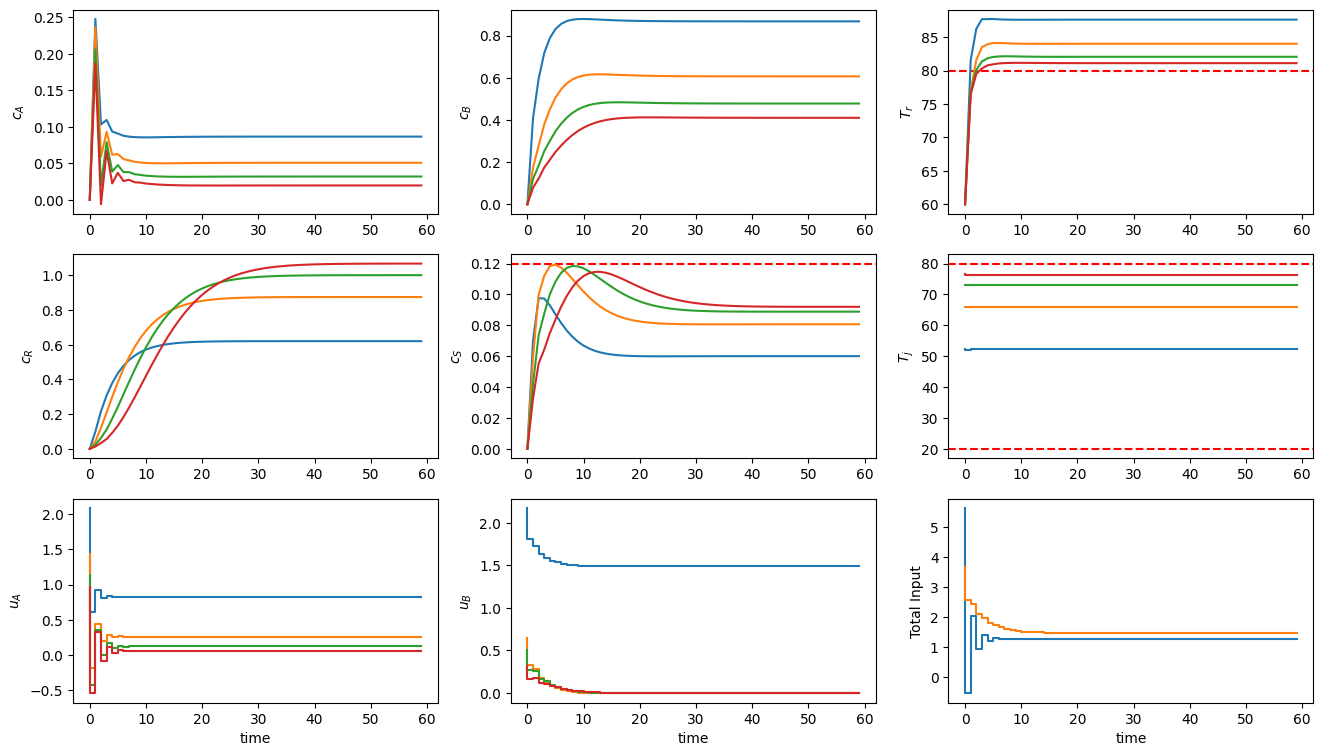

In [24]:
# plot the states
fig, ax = plt.subplots(3,3, sharex=False,sharey=False,figsize=(16,9))
ax[1,1].axhline(y=0.12,linestyle='--',color='red')
ax[0,2].axhline(y=80,linestyle='--',color='red')
ax[1,2].axhline(y=80,linestyle='--',color='red')
ax[1,2].axhline(y=20,linestyle='--',color='red')
ax[0,0].plot(LQR_res['_time'],LQR_res['_x','cA'])
ax[0,1].plot(LQR_res['_time'],LQR_res['_x','cB'])
ax[1,0].plot(LQR_res['_time'],LQR_res['_x','cR'])
ax[1,1].plot(LQR_res['_time'],LQR_res['_x','cS'])
ax[0,2].plot(LQR_res['_time'],LQR_res['_x','Tr'])
ax[1,2].step(LQR_res['_time'],LQR_res['_u','Tj'])
ax[2,0].step(LQR_res['_time'],LQR_res['_u','uA'])
ax[2,1].step(LQR_res['_time'],LQR_res['_u','uB'])
ax[2,2].step(LQR_res['_time'],np.sum(LQR_res['_u','uA'],axis=1))
ax[2,2].step(LQR_res['_time'],np.sum(LQR_res['_u','uB'],axis=1))


# Set labels
ax[0,0].set_ylabel('$c_A$')
ax[0,1].set_ylabel('$c_B$')
ax[1,0].set_ylabel('$c_R$')
ax[1,1].set_ylabel('$c_S$')
ax[2,0].set_ylabel('$u_A$')
ax[2,1].set_ylabel('$u_B$')
ax[0,2].set_ylabel('$T_r$')
ax[1,2].set_ylabel('$T_j$')
#ax[1,2].set_ylim([0,1])
ax[2,2].set_ylabel('Total Input')
ax[2,0].set_xlabel('time')
ax[2,1].set_xlabel('time')
ax[2,2].set_xlabel('time')

# Sampling Planner

In [25]:
sp = do_mpc.sampling.SamplingPlanner()
sp.set_param(overwrite = False)
sp.data_dir = './sampling_test/'

In [27]:
sp.set_sampling_var('par', lambda: np.random.uniform(0.7,1.3,size=cstr.n_reac*4))

In [28]:
plan = sp.gen_sampling_plan(n_samples=25)
plan = sp.add_sampling_case(par=1.3*np.ones((cstr.n_reac*4,)))
plan = sp.add_sampling_case(par=0.7*np.ones((cstr.n_reac*4,)))
plan = sp.add_sampling_case(par=1*np.ones((cstr.n_reac*4,)))

In [28]:
pd.DataFrame(plan)

,par,id
0,"[0.9278305153060482, 0.7911607376657407, 0.942...",000
1,"[0.9998091765786556, 1.194669528278097, 0.8602...",001
2,"[0.7411055249816343, 1.1902806026081216, 0.790...",002
3,"[1.1218901127900232, 1.0418993234578484, 1.238...",003
4,"[0.9845598852294045, 0.9359282492922045, 1.284...",004
5,"[0.7054636386486014, 0.7842151943169764, 1.043...",005
6,"[0.707552447681263, 1.2916261263971445, 1.0006...",006
7,"[0.8525326894853267, 1.1671572952289493, 1.145...",007
8,"[0.9326479967340391, 0.9296142059153333, 0.932...",008
9,"[1.0899575640114283, 1.1385661864511218, 0.897...",009


In [27]:
#sp.export('sampling_plan')
plan=np.load('sampling_test/sampling_plan.pkl',allow_pickle=True)

Sampler

In [31]:
sampler = do_mpc.sampling.Sampler(plan)
sampler.data_dir = './sampling_test/'
sampler.set_param(overwrite = False)

In [32]:
def run_closed_loops(par):
    sim_tvp_template=simulator.get_tvp_template()
    sim_tvp_template['k1_mean']=cstr.k1_0
    sim_tvp_template['k2_mean']=cstr.k2_0
    sim_p_template=simulator.get_p_template()
    sim_p_template['k1_var']=par[0:cstr.n_reac]
    sim_p_template['k2_var']=par[cstr.n_reac:2*cstr.n_reac]
    sim_tvp_template['delH1_mean']=cstr.delH1_0
    sim_tvp_template['delH2_mean']=cstr.delH2_0
    sim_p_template['delH1_var']=par[2*cstr.n_reac:3*cstr.n_reac]
    sim_p_template['delH2_var']=par[3*cstr.n_reac:]
    simulator.set_tvp_fun(lambda t: sim_tvp_template)
    simulator.set_p_fun(lambda t: sim_p_template)
    simulator.setup()
    
    mpc.reset_history()
    simulator.reset_history()
    x_0=0*np.ones((cstr.nx,1))
    x_0[-cstr.n_reac:]=cstr.Tr_in
    mpc.x0 = x_0

    mpc.set_initial_guess()
    mpc.opt_x_num['_u',:,:,'Tj']=cstr.Tr_in
    mpc.opt_x_num['_u',:,:,'uB',0]=1.5
    mpc.opt_x_num['_u',:,:,'uA',0]=1.5
    simulator.x0 = x_0
    x0 = simulator.x0
    
    N_iter = 50
    clc_mpc=np.zeros((N_iter+1,1))
    constr_viol_mpc=np.zeros((N_iter,1))
    tic=time.time()
    for k in range(N_iter):
        #CSTRmodel.print_progress(k,N_iter)
        print('MPC iteration {}/{}'.format(k,N_iter))
        u0 = mpc.make_step(x0)
        clc_mpc[k+1]=clc_mpc[k]+mpc.lterm_fun(x0,u0,0,0,0)
        constr_viol_mpc[k]+=np.sum(np.maximum(np.zeros((cstr.nx,1)),vertcat(*[mpc.bounds['upper','_x',key] for key in cstr.model.x.keys()])-x0))
        constr_viol_mpc[k]+=np.sum(np.maximum(np.zeros((cstr.nx,1)),x0-vertcat(*[mpc.bounds['lower','_x',key] for key in cstr.model.x.keys()])))
        x0 = simulator.make_step(u0)
    time_mpc=time.time()-tic
    clc_mpc=clc_mpc[1:]
    mpc_res = copy.copy(simulator.data)

    simulator.reset_history()
    MSmpc.reset_history()
    MSmpc.x0 = x_0

    MSmpc.set_initial_guess()
    MSmpc.opt_x_num['_u',:,:,'Tj']=cstr.Tr_in
    MSmpc.opt_x_num['_u',:,:,'uB',0]=1.5
    MSmpc.opt_x_num['_u',:,:,'uA',0]=1.5
    simulator.x0 = x_0

    x0 = simulator.x0
    clc_msmpc=np.zeros((N_iter+1,1))
    constr_viol_msmpc=np.zeros((N_iter,1))
    tic=time.time()
    for k in range(N_iter):
        #CSTRmodel.print_progress(k,N_iter)
        print('MS-MPC iteration {}/{}'.format(k,N_iter))
        u0 = MSmpc.make_step(x0)
        clc_msmpc[k+1]=clc_msmpc[k]+mpc.lterm_fun(x0,u0,0,0,0)
        constr_viol_msmpc[k]+=np.sum(np.maximum(np.zeros((cstr.nx,1)),vertcat(*[mpc.bounds['upper','_x',key] for key in cstr.model.x.keys()])-x0))
        constr_viol_msmpc[k]+=np.sum(np.maximum(np.zeros((cstr.nx,1)),x0-vertcat(*[mpc.bounds['lower','_x',key] for key in cstr.model.x.keys()])))
        x0 = simulator.make_step(u0)
    time_msmpc=time.time()-tic
    clc_msmpc=clc_msmpc[1:]
    msmpc_res = copy.copy(simulator.data)

    simulator.reset_history()
    
    LQR.set_setpoint(xss=x_ss,uss=u_ss)
    simulator.x0 = x_0

    x0 = vertcat(simulator.x0)
    clc_lqr=np.zeros((N_iter+1,1))
    constr_viol_lqr=np.zeros((N_iter,1))
    tic=time.time()
    for k in range(N_iter):
        print('LQR iteration {}/{}'.format(k,N_iter))
        u0 = LQR.make_step(x0)
        clc_lqr[k+1]=clc_lqr[k]+mpc.lterm_fun(x0,u0,0,0,0)
        constr_viol_lqr[k]+=np.sum(np.maximum(np.zeros((cstr.nx,1)),vertcat(*[mpc.bounds['upper','_x',key] for key in cstr.model.x.keys()])-x0))
        constr_viol_lqr[k]+=np.sum(np.maximum(np.zeros((cstr.nx,1)),x0-vertcat(*[mpc.bounds['lower','_x',key] for key in cstr.model.x.keys()])))
        x0 = simulator.make_step(u0)
    time_lqr=time.time()-tic
    clc_lqr=clc_lqr[1:]    
    lqr_res = copy.copy(simulator.data)

    return {'MPC':{'data':mpc_res,'CLC':clc_mpc,'Viol':constr_viol_mpc,'time':time_mpc},'MS-MPC':{'data':msmpc_res,'CLC':clc_msmpc,'Viol':constr_viol_msmpc,'time':time_msmpc},'LQR':{'data':lqr_res,'CLC':clc_lqr,'Viol':constr_viol_lqr,'time':time_lqr}}

sampler.set_sample_function(run_closed_loops)


In [33]:
# %%capture
# Generate the data
sampler.sample_data()


MPC iteration 0/50
MPC iteration 1/50
MPC iteration 2/50
MPC iteration 3/50
MPC iteration 4/50
MPC iteration 5/50
MPC iteration 6/50
MPC iteration 7/50
MPC iteration 8/50
MPC iteration 9/50
MPC iteration 10/50
MPC iteration 11/50
MPC iteration 12/50
MPC iteration 13/50
MPC iteration 14/50
MPC iteration 15/50
MPC iteration 16/50
MPC iteration 17/50
MPC iteration 18/50
MPC iteration 19/50
MPC iteration 20/50
MPC iteration 21/50
MPC iteration 22/50
MPC iteration 23/50
MPC iteration 24/50
MPC iteration 25/50
MPC iteration 26/50
MPC iteration 27/50
MPC iteration 28/50
MPC iteration 29/50
MPC iteration 30/50
MPC iteration 31/50
MPC iteration 32/50
MPC iteration 33/50
MPC iteration 34/50
MPC iteration 35/50
MPC iteration 36/50
MPC iteration 37/50
MPC iteration 38/50
MPC iteration 39/50
MPC iteration 40/50
MPC iteration 41/50
MPC iteration 42/50
MPC iteration 43/50
MPC iteration 44/50
MPC iteration 45/50
MPC iteration 46/50
MPC iteration 47/50
MPC iteration 48/50
MPC iteration 49/50
MS-MPC ite

## Post processing

In [50]:
dh = do_mpc.sampling.DataHandler(plan)
dh.data_dir = 'sampling_test/'

In [51]:
dh.set_post_processing('dataMPC', lambda data: data['MPC']['data'])
dh.set_post_processing('CLCMPC', lambda data: data['MPC']['CLC'])
dh.set_post_processing('VioMPC', lambda data: data['MPC']['Viol'])
dh.set_post_processing('timeMPC', lambda data: data['MPC']['time'])

dh.set_post_processing('dataMSMPC', lambda data: data['MS-MPC']['data'])
dh.set_post_processing('CLCMSMPC', lambda data: data['MS-MPC']['CLC'])
dh.set_post_processing('VioMSMPC', lambda data: data['MS-MPC']['Viol'])
dh.set_post_processing('timeMSMPC', lambda data: data['MS-MPC']['time'])

dh.set_post_processing('dataLQR', lambda data: data['LQR']['data'])
dh.set_post_processing('CLCLQR', lambda data: data['LQR']['CLC'])
dh.set_post_processing('VioLQR', lambda data: data['LQR']['Viol'])
dh.set_post_processing('timeLQR', lambda data: data['LQR']['time'])


In [52]:
res=dh[:]

In [53]:
idx_plot=25

In [54]:
res[idx_plot]['par']

array([1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3,
       1.3, 1.3, 1.3])

In [60]:
ub_Tj=np.array(mpc.bounds['upper','_u','Tj'][0])
lb_Tj=np.array(mpc.bounds['lower','_u','Tj'][0])
ub_cS=np.array(mpc.bounds['upper','_x','cS'][0])

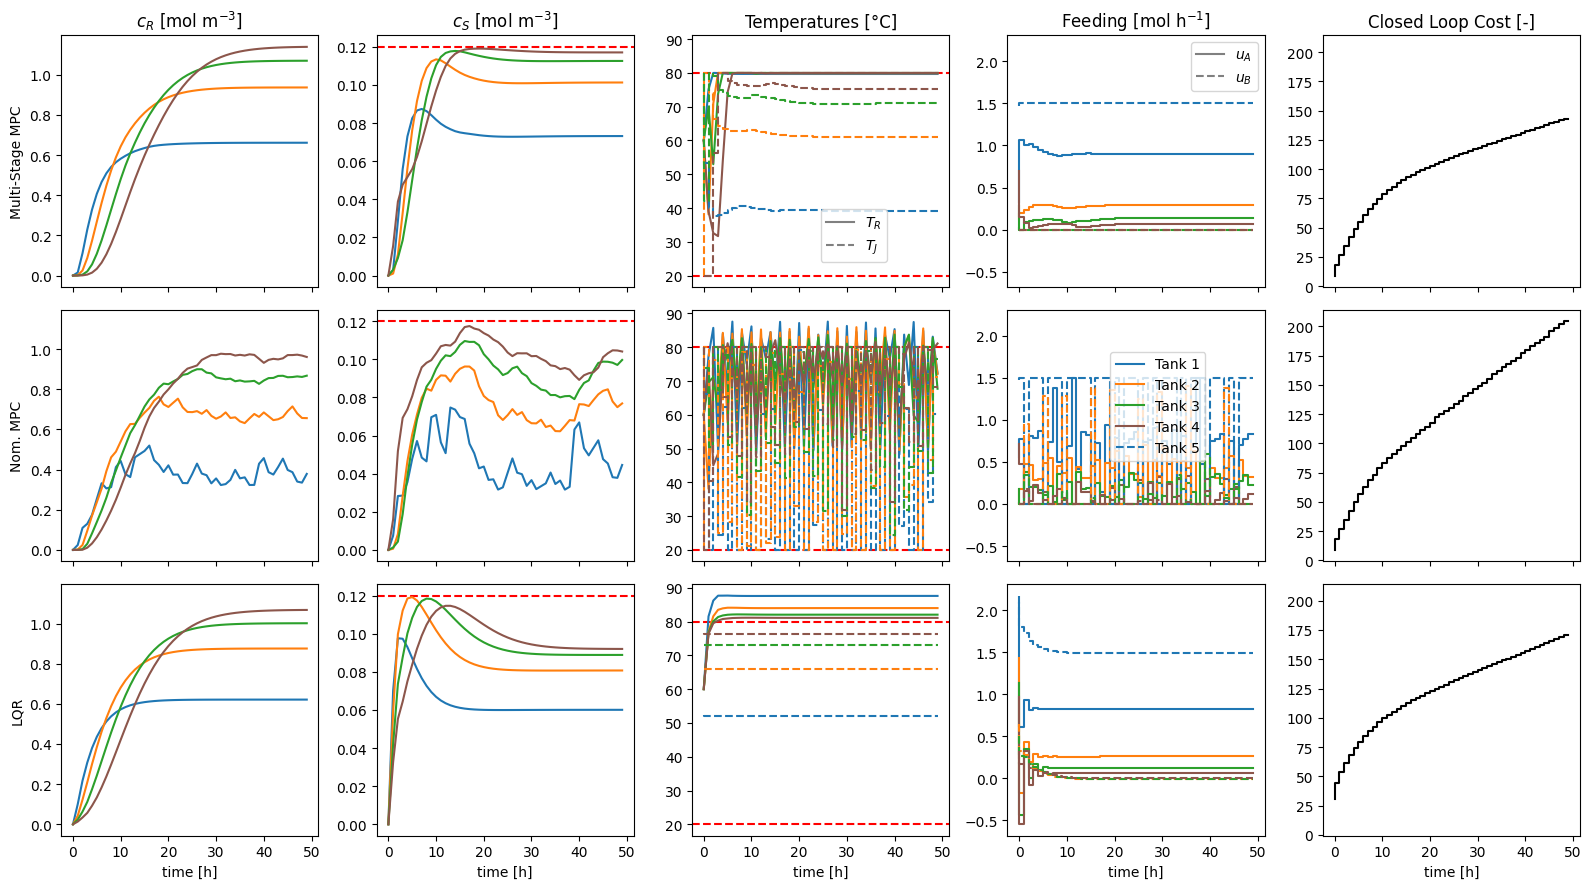

In [61]:
size=1
fig, ax = plt.subplots(3,5,sharex=True, sharey='col', figsize=(size*16,size*9))
for i in range(5):
    for j in range(3):
        ax[j,i].set_prop_cycle(color=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:purple'])
        
        
for i in range(3):
    ax[i,2].axhline(y=ub_Tj,linestyle='--',color='red')
    ax[i,2].axhline(y=lb_Tj,linestyle='--',color='red')
    ax[i,1].axhline(y=ub_cS,linestyle='--',color='red')
ax[0,2].plot(res[idx_plot]['dataMSMPC']['_time'],res[idx_plot]['dataMSMPC']['_x','Tr'])
ax[1,2].plot(res[idx_plot]['dataMPC']['_time'],res[idx_plot]['dataMPC']['_x','Tr'])
ax[2,2].plot(res[idx_plot]['dataLQR']['_time'],res[idx_plot]['dataLQR']['_x','Tr'])


ax[0,0].plot(res[idx_plot]['dataMSMPC']['_time'],res[idx_plot]['dataMSMPC']['_x','cR'])
ax[1,0].plot(res[idx_plot]['dataMPC']['_time'],res[idx_plot]['dataMPC']['_x','cR'])
ax[2,0].plot(res[idx_plot]['dataLQR']['_time'],res[idx_plot]['dataLQR']['_x','cR'])

ax[0,1].plot(res[idx_plot]['dataMSMPC']['_time'],res[idx_plot]['dataMSMPC']['_x','cS'])
ax[1,1].plot(res[idx_plot]['dataMPC']['_time'],res[idx_plot]['dataMPC']['_x','cS'])
ax[2,1].plot(res[idx_plot]['dataLQR']['_time'],res[idx_plot]['dataLQR']['_x','cS'])

ax[0,4].step(res[idx_plot]['dataLQR']['_time'],res[idx_plot]['CLCMSMPC'],'black')
ax[1,4].step(res[idx_plot]['dataLQR']['_time'],res[idx_plot]['CLCMPC'],'black')
ax[2,4].step(res[idx_plot]['dataLQR']['_time'],res[idx_plot]['CLCLQR'],'black')


ax[0,3].step(res[idx_plot]['dataMSMPC']['_time'],res[idx_plot]['dataMSMPC']['_u','uA'])
ax[1,3].step(res[idx_plot]['dataMPC']['_time'],res[idx_plot]['dataMPC']['_u','uA'])
ax[2,3].step(res[idx_plot]['dataLQR']['_time'],res[idx_plot]['dataLQR']['_u','uA'])

ax[0,3].set_prop_cycle(color=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:purple'])
ax[1,3].set_prop_cycle(color=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:purple'])
ax[2,3].set_prop_cycle(color=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:purple'])

ax[0,3].step(res[idx_plot]['dataMSMPC']['_time'],res[idx_plot]['dataMSMPC']['_u','uB'],'--',linewidth=1.5)
ax[1,3].step(res[idx_plot]['dataMPC']['_time'],res[idx_plot]['dataMPC']['_u','uB'],'--',linewidth=1.5)
ax[2,3].step(res[idx_plot]['dataLQR']['_time'],res[idx_plot]['dataLQR']['_u','uB'],'--',linewidth=1.5)

ax[0,2].set_prop_cycle(color=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:purple'])
ax[1,2].set_prop_cycle(color=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:purple'])
ax[2,2].set_prop_cycle(color=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:purple'])
ax[0,2].step(res[idx_plot]['dataMSMPC']['_time'],res[idx_plot]['dataMSMPC']['_u','Tj'],'--',linewidth=1.5)
ax[1,2].step(res[idx_plot]['dataMPC']['_time'],res[idx_plot]['dataMPC']['_u','Tj'],'--',linewidth=1.5)
ax[2,2].step(res[idx_plot]['dataLQR']['_time'],res[idx_plot]['dataLQR']['_u','Tj'],'--',linewidth=1.5)


for i in range(5):
    ax[-1,i].set_xlabel('time [h]')
ax[0,1].set_title('$c_S$ [mol m$^{-3}$]',y=1)
ax[0,0].set_title('$c_R$ [mol m$^{-3}$]',y=1.)
ax[0,2].set_title('Temperatures [°C]',y=1.)
ax[0,3].set_title('Feeding [mol h$^{-1}$]',y=1)
ax[0,4].set_title('Closed Loop Cost [-]',y=1)

lineuA=mpl.lines.Line2D([],[],color='grey',label='$u_A$')
lineuB=mpl.lines.Line2D([],[],linestyle='--',color='grey',label='$u_B$')
ax[0,3].legend(handles=[lineuA,lineuB])

lineTr=mpl.lines.Line2D([],[],color='grey',label='$T_R$')
lineTj=mpl.lines.Line2D([],[],linestyle='--',color='grey',label='$T_J$')
ax[0,2].legend(handles=[lineTr,lineTj],loc=[0.5,0.1])

ax[1,3].legend(['Tank 1','Tank 2','Tank 3','Tank 4','Tank 5'],fontsize='medium', loc=[0.4,0.4])

ax[2,0].set_ylabel('LQR')
ax[0,0].set_ylabel('Multi-Stage MPC')
ax[1,0].set_ylabel('Nom. MPC')


fig.align_labels()
fig.tight_layout()
